##Collect Data

In [ ]:
!pip install pyheif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 42.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
data_dir = '/gdrive/MyDrive/project1/handwritten_digit_classification/DATA'

Mounted at /gdrive


##Prepared Dataset

In [ ]:
import os
import glob

image_lists = []
for folder in glob.glob(f'{data_dir}/*/hand_written_digit/??52????'):
    for num in range(10):
        for img_path in glob.glob(f'{folder}/{num}_*'):
            image_lists.append((img_path, num))

print("Sample of image_lists:")
for item in image_lists[:5]:
    print(item, type(item), len(item))

Sample of image_lists:
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image132.jpg', 0) <class 'tuple'> 2
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image87.jpg', 0) <class 'tuple'> 2
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image39.jpg', 0) <class 'tuple'> 2
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image131.jpg', 0) <class 'tuple'> 2
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image36.jpg', 0) <class 'tuple'> 2


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import pyheif
import io

class custom_image_dataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        ext = os.path.splitext(img_path)[1].lower()

        try:
            if ext == '.heic':
                heif_file = pyheif.read(img_path)
                image = Image.frombytes(
                    heif_file.mode,
                    heif_file.size,
                    heif_file.data,
                    "raw",
                    heif_file.mode,
                    heif_file.stride,
                )
                image = image.convert('RGB')
            else:
                image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label), img_path
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            raise ValueError(f"Cannot read image: {img_path}")

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import os
from PIL import Image
import pyheif
import io

def is_valid_image(item):
    path, label = item
    if not os.path.isfile(path):
        print(f"Invalid file (does not exist): {path}")
        return None

    ext = os.path.splitext(path)[1].lower()

    supported_extensions = ['.jpg', '.jpeg', '.png', '.heic']

    if ext not in supported_extensions:
        print(f"Invalid image (unsupported extension): {path}")
        return None

    try:
        if ext == '.heic':
            heif_file = pyheif.read(path)
            if heif_file:
                return (path, label)
            else:
                print(f"Invalid HEIC image: {path}")
                return None
        else:
            with Image.open(path) as img:
                img.verify()
            return (path, label)
    except Exception as e:
        print(f"Error validating image {path}: {e}")
        return None

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(is_valid_image, image_lists))

valid_image_lists = [r for r in results if r is not None]
print(f"Total valid images: {len(valid_image_lists)}")

Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_1_blue.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_1_red.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_3_red.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_2_red.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_5_red.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_writ

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

split = int(0.8 * len(valid_image_lists))
train_dataset = custom_image_dataset(valid_image_lists[:split], train_transform)
test_dataset = custom_image_dataset(valid_image_lists[split:], test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_counts = np.zeros(10)
for _, label in valid_image_lists[:split]:
    class_counts[label] += 1
class_weights = 1.0 / (class_counts + 1e-5)
class_weights = class_weights / class_weights.sum() * 10
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

for inputs, labels, paths in train_dataloader:
    print(f"Batch size: {len(labels)}")
    print(f"Input shape: {inputs.shape}")
    print(f"Label type: {type(labels)}")
    print(f"Labels: {labels}")
    break

Batch size: 32
Input shape: torch.Size([32, 3, 224, 224])
Label type: <class 'torch.Tensor'>
Labels: tensor([8, 5, 5, 6, 8, 2, 1, 1, 8, 6, 7, 4, 2, 1, 2, 9, 8, 8, 0, 6, 1, 4, 5, 4,
        1, 6, 9, 8, 5, 2, 3, 4])


##Build Model ResNet50

In [ ]:
from torchvision import models
import torch.nn as nn

# Dùng ResNet50 pretrained
model = models.resnet50(pretrained=True)

# Chỉnh lại lớp cuối để phân loại 10 lớp (0–9)
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##Training

In [ ]:
import torch.optim as optim

# Dùng class_weights bạn đã tính sẵn trước đó
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_loop(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels, _) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 19:
            print(f'[Batch {i + 1}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0
    return running_loss / len(dataloader)

def test_loop(dataloader, model, criterion):
    model.eval()
    total = 0
    correct = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(dataloader)
    accuracy = 100 * correct / total
    print(f'Test Error: \n Accuracy: {accuracy:.1f}%, Avg loss: {test_loss:.3f} \n')
    return test_loss, accuracy

Epoch 1
-------------------------------
[Batch 20] loss: 2.149
[Batch 40] loss: 1.720
[Batch 60] loss: 1.432
[Batch 80] loss: 1.205
[Batch 100] loss: 1.231
[Batch 120] loss: 1.199
[Batch 140] loss: 1.140
[Batch 160] loss: 0.921
Test Error: 
 Accuracy: 64.2%, Avg loss: 1.186 

Epoch 2
-------------------------------
[Batch 20] loss: 0.903
[Batch 40] loss: 0.806
[Batch 60] loss: 0.729
[Batch 80] loss: 0.856
[Batch 100] loss: 0.676
[Batch 120] loss: 0.804
[Batch 140] loss: 0.691
[Batch 160] loss: 0.680
Test Error: 
 Accuracy: 66.5%, Avg loss: 1.164 

Epoch 3
-------------------------------
[Batch 20] loss: 0.564
[Batch 40] loss: 0.647
[Batch 60] loss: 0.612
[Batch 80] loss: 0.532
[Batch 100] loss: 0.485
[Batch 120] loss: 0.497
[Batch 140] loss: 0.680
[Batch 160] loss: 0.641
Test Error: 
 Accuracy: 70.0%, Avg loss: 0.983 

Epoch 4
-------------------------------
[Batch 20] loss: 0.472
[Batch 40] loss: 0.548
[Batch 60] loss: 0.559
[Batch 80] loss: 0.564
[Batch 100] loss: 0.485
[Batch 120] l

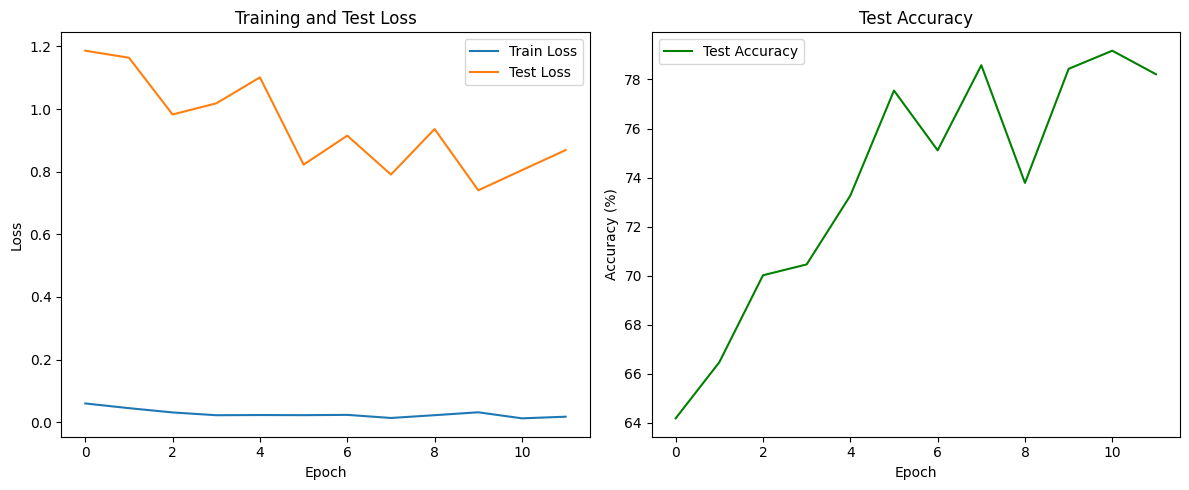

Finished Training!


<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []
test_accuracies = []
best_loss = float('inf')
epochs_no_improve = 0
best_model_path = f'{data_dir}/best_model_resnet50.pth'
epochs = 12
patience = 5

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print('Finished Training!')
model.load_state_dict(torch.load(best_model_path))

##Dự đoán

In [ ]:
!pip install pillow_heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.1 MB/s eta 0:00:00


In [ ]:
import os
import torch
from PIL import Image
import pillow_heif
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

# Thư mục chứa ảnh cần dự đoán
test_folder = '/gdrive/MyDrive/project1/handwritten_digit_classification/cs114_hwdr'

# Tìm tất cả các ảnh hợp lệ (.jpg, .png, .heic, ...)
test_image_paths = []
for root, _, files in os.walk(test_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.heic')):
            test_image_paths.append(os.path.join(root, file))

print(f"Tìm thấy {len(test_image_paths)} ảnh hợp lệ.")

Mounted at /gdrive
Tìm thấy 2928 ảnh hợp lệ.


In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            if img_path.lower().endswith('.heic'):
                heif_file = pillow_heif.read_heif(img_path)
                image = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data)
            else:
                image = Image.open(img_path)
            image = image.convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_path
        except Exception as e:
            print(f"Lỗi ảnh: {img_path} ({e})")
            return torch.zeros((3, 200, 200)), img_path

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = TestImageDataset(test_image_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tạo lại đúng kiến trúc ResNet50 với 10 lớp output
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)

# Load trọng số
model_path = '/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/best_model_resnet50.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Mô hình ResNet50 đã được load thành công!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Mô hình ResNet50 đã được load thành công!


In [ ]:
predictions = []

with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for img_path, label in zip(paths, preds):
            predictions.append((os.path.basename(img_path), label.item()))

print(f"Đã dự đoán xong {len(predictions)} ảnh.")

Đã dự đoán xong 2928 ảnh.


In [ ]:
import csv

output_csv = '/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/predictions_resnet50.csv'

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    #writer.writerow(['filename', 'predicted_label'])
    for filename, label in predictions:
        writer.writerow([filename, label])

print(f"Kết quả đã lưu vào: {output_csv}")

Kết quả đã lưu vào: /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/predictions_resnet50.csv


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Evaluation Metrics:


,Metric,Score
0,Accuracy,0.784343
1,F1-score,0.784369
2,Precision,0.801117
3,Recall,0.784343


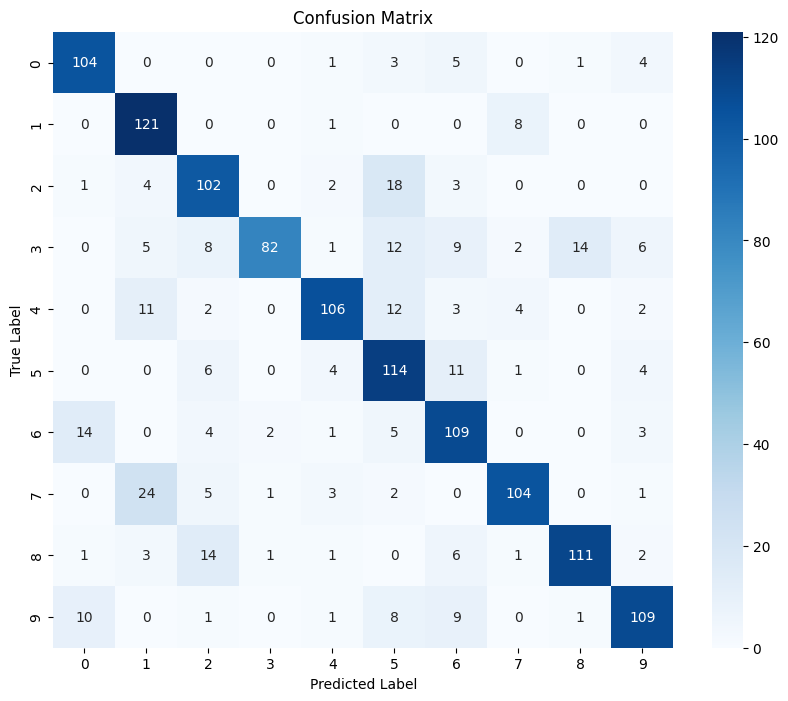

In [ ]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for images, labels, _ in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

metrics_data = {'Metric': ['Accuracy', 'F1-score', 'Precision', 'Recall'],
                'Score': [accuracy, f1, precision, recall]}
metrics_df = pd.DataFrame(metrics_data)
print("Evaluation Metrics:")
display(metrics_df)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()